In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_path = r"D:\USTH\Year_3\MachineLearning in Med\mlmed2025\Prac2\training_set"
image_files = sorted([f for f in os.listdir(train_path) if '_HC.png' in f and 'Annotation' not in f])

img_size = 128

images = []
masks = []

for img_file in image_files:
    img_path = os.path.join(train_path, img_file)
    mask_path = os.path.join(train_path, img_file.replace('.png', '_Annotation.png'))

    # Preprocess
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = mask / 255.0  

    images.append(img)
    masks.append(mask)

X = np.array(images).reshape(-1, img_size, img_size, 1)
y = np.array(masks).reshape(-1, img_size, img_size, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (644, 128, 128, 1), Test shape: (162, 128, 128, 1)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs, outputs)
    return model

unet_model = build_unet((img_size, img_size, 1))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    restore_best_weights=True 
)    
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=20,
    callbacks=[early_stop] 
)



Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - accuracy: 0.9794 - loss: 0.3862 - val_accuracy: 0.9888 - val_loss: 0.0604
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.9887 - loss: 0.0527 - val_accuracy: 0.9888 - val_loss: 0.0426
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.9888 - loss: 0.0418 - val_accuracy: 0.9888 - val_loss: 0.0398
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9888 - loss: 0.0390 - val_accuracy: 0.9888 - val_loss: 0.0366
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.9887 - loss: 0.0366 - val_accuracy: 0.9888 - val_loss: 0.0352
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.9888 - loss: 0.0354 - val_accuracy: 0.9888 - val_loss: 0.0350
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9888 - loss: 0.0349 - val_accuracy: 0.9888 - val_loss: 0.0343
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 383ms/step - accuracy: 0.9887 - loss: 0.0346 - val_accu

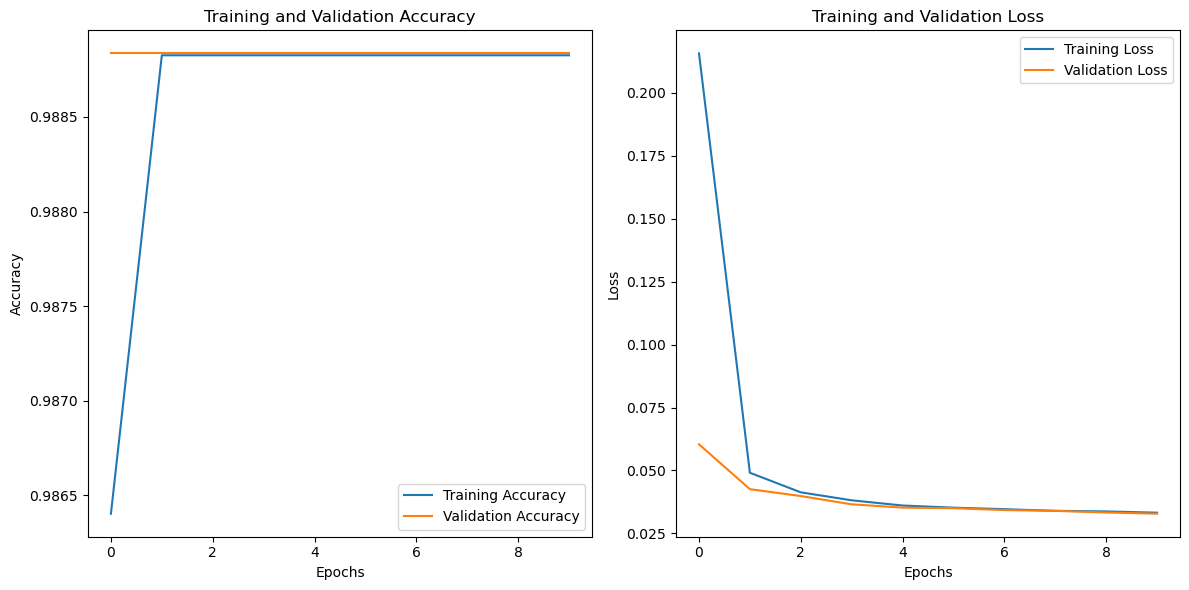

In [14]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()